In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from fbprophet import Prophet

%matplotlib inline

In [3]:
plt.style.use('ggplot')

In [4]:
def price_range(prod_category, price):
    """
    Function to categorize price ranges of product categories
    """
    prices = price_cat[prod_category]
    if price < prices[0]:
        return 'A'
    elif price < prices[1]:
        return 'B'
    elif price < prices[2]:
        return 'C'
    else:
        return 'D'

In [299]:
def get_holidays():
    """
    Get Black Friday dates
    """
    black_friday = pd.DataFrame({
                  'holiday': 'black_friday',
                  'ds': pd.to_datetime(['2017-11-24', '2018-11-23', '2019-11-29',
                                        '2020-11-27', '2021-11-26', '2022-11-25',
                                        '2023-11-24', '2024-11-29', '2025-11-28']),
                  'lower_window': -1,
                  'upper_window': 3,
                })

    xmas = pd.DataFrame({
                  'holiday': 'christmas',
                  'ds': pd.to_datetime(['2017-12-25', '2018-12-25', '2019-12-25',
                                        '2020-12-25', '2021-12-25', '2022-12-25',
                                        '2023-12-25', '2024-12-25', '2025-12-25']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    new_year = pd.DataFrame({
                  'holiday': 'new_year',
                  'ds': pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01',
                                        '2020-01-01', '2021-01-01', '2022-01-01',
                                        '2023-01-01', '2024-01-01', '2025-01-01']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    carnival = pd.DataFrame({
                  'holiday': 'carnival',
                  'ds': pd.to_datetime(['2017-02-28', '2018-02-13', '2019-03-05',
                                        '2020-02-25', '2021-02-16', '2022-03-01',
                                        '2023-02-21', '2024-02-13', '2025-03-04']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    good_friday = pd.DataFrame({
                  'holiday': 'good_friday',
                  'ds': pd.to_datetime(['2018-03-18','2019-04-19','2020-04-10',
                                        '2021-04-02','2022-04-15','2023-04-07',
                                        '2024-03-29']),
                  'lower_window': 0,
                  'upper_window': 2,
                })

    valentines = pd.DataFrame({
                  'holiday': 'valentines',
                  'ds': pd.to_datetime(['2019-06-12','2020-06-12','2021-06-12']),
                  'lower_window': -7,
                  'upper_window': 0,
                })
    
    mothers_day = pd.DataFrame({
                  'holiday': 'mothers_day',
                  'ds': pd.to_datetime(['2018-05-13','2019-05-12']),
                  'lower_window': -7,
                  'upper_window': 0,
                })
    # long holidays

    monday = pd.DataFrame({
                  'holiday': 'monday',
                  'ds': pd.to_datetime(['2020-09-07','2020-10-12','2020-11-02',
                                        '2021-11-15']),
                  'lower_window': -2,
                  'upper_window': 0,
                })

    friday = pd.DataFrame({
                  'holiday': 'friday',
                  'ds': pd.to_datetime(['2018-09-07','2018-10-12','2018-11-02',
                                        '2019-11-15','2020-05-01']),
                  'lower_window': 0,
                  'upper_window': 2,
                })

    # Different cases
    # 2019-12-30 (christmas and New year's eve from tuesday to wednesday. Monday was also affected)
    others = pd.DataFrame({
                  'holiday': 'others',
                  'ds': pd.to_datetime(['2019-12-23','2019-12-30']),
                  'lower_window': 0,
                  'upper_window': 0,
                })

    holidays = pd.concat((black_friday, xmas, new_year, carnival, valentines, mothers_day,
                         monday, friday, others))

    return holidays

In [300]:
# get holidays dataframe
holidays = get_holidays()

# transform holidays
hday=[]
hdate=[]
for row in holidays.itertuples():
    lower = row.lower_window
    upper = row.upper_window
    holiday  = row.holiday
    day = row.ds
    
#     if upper == 0 and lower == 0:
#         hday.append(holiday)
#         hdate.append(day + timedelta(days=i))

    for i in range(lower, upper+1):
        hday.append(holiday)
        hdate.append(day + timedelta(days=i))
        
hdays = pd.DataFrame(zip(hday,hdate), columns=['holiday','ds'])

In [301]:
# Read data
data = pd.read_csv('s3://bsa-correlation-one/electronics_data.csv', dtype={'gtin':'str'})

# Select columns to use
df = data[['date', 'product_group','product_type', 'olist_price',
           'competition_price','freight_value','stock_max', 'orders']].copy()

# Round monetary values
df['olist_price'] = round(df.olist_price,2)
df['competition_price'] = round(df.competition_price,2)

# Create price ranges
price_cat = {}
for prod_type in df.product_type.unique():
    temp = df[df.product_type == prod_type].copy()
    price_cat[prod_type] = np.quantile(temp.olist_price.values, np.arange(0.25, 1, 0.25))

# Categorize product by price range
df['price_category'] = df.apply(lambda row: price_range(row['product_type'], row['olist_price']), axis=1)

# Group measures by date, product group, type and price category
df = df.groupby(['date','product_group','product_type','price_category'])\
       .agg({'olist_price': 'mean', 'competition_price':'mean', 'freight_value':'mean',
             'stock_max':'sum', 'orders':'sum'}).reset_index()

# Concatenate group, type and price range in new column
df['group_type_price'] = df.product_group + '_' + df.product_type + '_' + df.price_category

# 
df = df[['date','group_type_price','olist_price', 'competition_price','freight_value', 'stock_max', 'orders']].copy()

# Change type of date and rename columns
df['date'] = pd.to_datetime(df['date'])
df.rename(columns={'date':'ds', 'orders':'y'}, inplace=True)

# get date parameters
df['year']      = df['ds'].apply(lambda x: x.year)
df['month']     = df['ds'].apply(lambda x: x.month)
df['dayofweek'] = df['ds'].apply(lambda x: x.dayofweek)
df['day']       = df['ds'].apply(lambda x: x.day)


df = pd.merge(df, hdays, left_on='ds', right_on='ds', how='left')

# one-hot encode holidays
one_hot = pd.get_dummies(data=df['holiday'], dummy_na=True)
# drop nan col (will serve to avoid multicollinearity)
one_hot.drop(columns=[np.nan], inplace=True)

# drop holiday columns
df.drop(columns=['holiday'], inplace=True)

# Join df with one-hot
data = df.join(one_hot)

data = data[['ds', 'year', 'month', 'day', 'dayofweek', 'group_type_price',
             'olist_price', 'competition_price', 'freight_value', 'stock_max', 
             'black_friday', 'carnival', 'christmas', 'friday', 'new_year', 'others',
             'y']]

del df

In [302]:
data.head()

,ds,year,month,day,dayofweek,group_type_price,olist_price,competition_price,freight_value,stock_max,black_friday,carnival,christmas,friday,new_year,others,y
0,2017-06-30,2017,6,30,4,electronics_Celular_A,149.90,NaN,NaN,20.0,0,0,0,0,0,0,0.0
1,2017-06-30,2017,6,30,4,electronics_Celular_B,349.90,NaN,NaN,10.0,0,0,0,0,0,0,0.0
2,2017-06-30,2017,6,30,4,electronics_Celular_C,813.63,NaN,NaN,5.0,0,0,0,0,0,0,0.0
3,2017-06-30,2017,6,30,4,electronics_Controle remoto_D,42.50,NaN,NaN,0.0,0,0,0,0,0,0,0.0
4,2017-06-30,2017,6,30,4,electronics_Microfone_A,39.95,NaN,NaN,0.0,0,0,0,0,0,0,0.0


In [303]:
category = 'electronics_Celular_C'

df = data[data.group_type_price == category].copy()
df.set_index('ds', inplace=True)

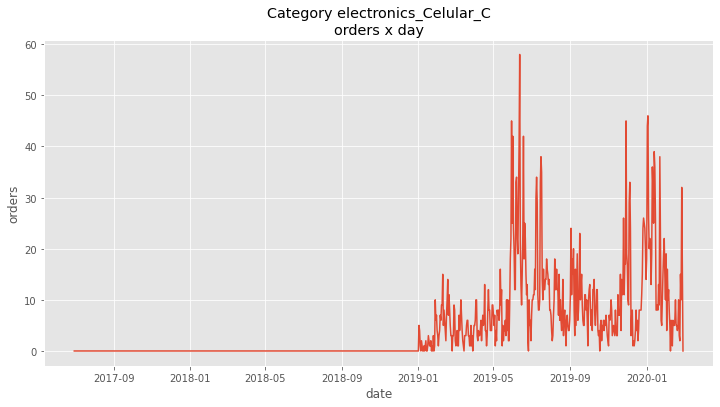

In [304]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df.index, y=df.y)
plt.title('Category {}\norders x day'.format(category))
plt.ylabel('orders')
plt.xlabel('date')
plt.show()

Since we have many trailing days with 0 orders, let's consider only the dates after the first sale.

In [309]:
# Getting dates after first sale
df = data[data.group_type_price == category].copy()
df.reset_index(drop=True, inplace=True)
first_valid = df[df.y > 0].index[0]
df = df.iloc[first_valid:].copy()
df.reset_index(drop=True, inplace=True)

# Filling null values ()
df['olist_price'].fillna(method='ffill',inplace=True)
df['competition_price'].fillna(method='ffill',inplace=True)
df['freight_value'].fillna(method='ffill',inplace=True)
df['freight_value'].fillna(value=temp['freight_value'].median(), inplace=True)

df.loc[(df["competition_price"].isnull()) & (df['y']>0),'competition_price'] = df['olist_price']

df['l1_diff'] = df.y - df.y.shift(1)
df['y-1']  = df.y.shift(1)
df['y-2']  = df.y.shift(2)
df['y-3']  = df.y.shift(3)
df['y-4']  = df.y.shift(4)
df['y-5']  = df.y.shift(5)
df['y-6']  = df.y.shift(6)
df['y-7']  = df.y.shift(7)
df['y-8']  = df.y.shift(8)
df['y-9']  = df.y.shift(9)
df['y-10'] = df.y.shift(10)

df.dropna(subset=['l1_diff','y-1','y-2','y-3','y-4','y-5',
                  'y-6','y-7','y-8','y-9','y-10'], inplace=True)

Now let's see how our timeseries look

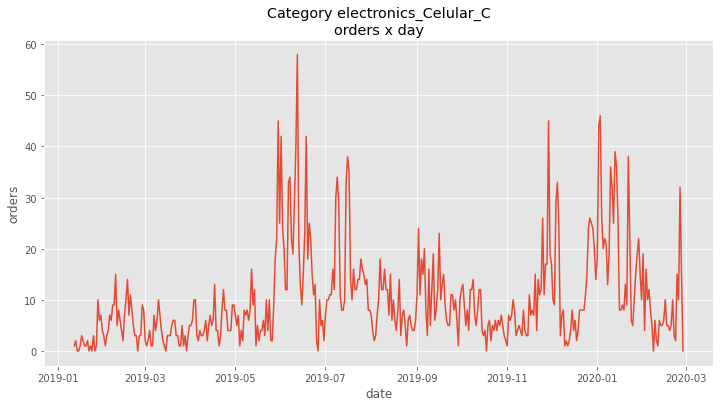

In [310]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df.ds, y=df.y)
plt.title('Category {}\norders x day'.format(category))
plt.ylabel('orders')
plt.xlabel('date')
plt.show()

#### Alternative: Make data stationary

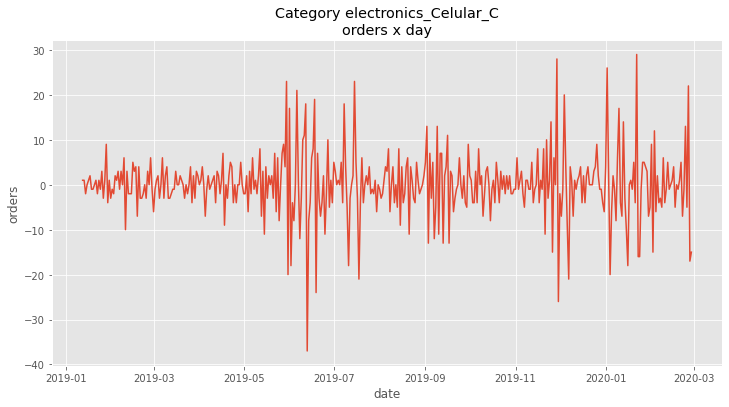

In [311]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df.ds, y=df.l1_diff)
plt.title('Category {}\norders x day'.format(category))
plt.ylabel('orders')
plt.xlabel('date')
plt.show()

#### Augmented Dicky-fuller test

In [312]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.l1_diff.dropna())
print('p-value: %f' % result[1])
if result[1] < 0.05:
    print("Reject the null hypothesis")
    print("Data is stationary")
else:
    print("Fail to reject null hypothesis")

print()
print('ADF Statistic: %f' % result[0])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

p-value: 0.000000
Reject the null hypothesis
Data is stationary

ADF Statistic: -10.779131
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571


## Testing Models

- Baseline model (avg?)
- Linear Regression
- Decision Trees
- Random Forest
- SVM
- XGBoost
- AdaBoost Regressor
- Gradient Boosting Regression

- ARIMA
- Holt-Winters
- VAR (Vector Auto Regression?)

- fbprophet (?)
- Neural Network / LSTM

Metrics:
- MAE
- RMSE

In [313]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [314]:
split_point = round(df.shape[0] * 0.88)

train = df.iloc[:split_point].drop(columns=['ds','group_type_price'])
test  = df.iloc[split_point:].drop(columns=['ds','group_type_price'])

In [315]:
train.head()

,year,month,day,dayofweek,olist_price,competition_price,freight_value,stock_max,black_friday,carnival,...,y-1,y-2,y-3,y-4,y-5,y-6,y-7,y-8,y-9,y-10
10,2019,1,12,5,789.586949,783.013704,23.830,720.0,0,0,...,0.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,4.0,5.0
11,2019,1,13,6,791.105410,783.013704,23.755,730.0,0,0,...,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,4.0
12,2019,1,14,0,805.694333,799.450000,23.755,739.0,0,0,...,2.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0
13,2019,1,15,1,805.507419,802.890000,23.755,744.0,0,0,...,0.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0
14,2019,1,16,2,807.042059,805.631481,29.030,766.0,0,0,...,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0


In [316]:
test.head()

,year,month,day,dayofweek,olist_price,competition_price,freight_value,stock_max,black_friday,carnival,...,y-1,y-2,y-3,y-4,y-5,y-6,y-7,y-8,y-9,y-10
373,2020,1,10,4,752.919464,700.042059,10.806212,6441.0,0,0,...,19.0,13.0,21.0,22.0,20.0,26.0,46.0,44.0,18.0,14.0
374,2020,1,11,5,756.193208,715.307813,10.504643,4916.0,0,0,...,36.0,19.0,13.0,21.0,22.0,20.0,26.0,46.0,44.0,18.0
375,2020,1,12,6,752.873455,712.048529,11.487652,5009.0,0,0,...,32.0,36.0,19.0,13.0,21.0,22.0,20.0,26.0,46.0,44.0
376,2020,1,13,0,751.116111,713.015152,9.481125,4918.0,0,0,...,25.0,32.0,36.0,19.0,13.0,21.0,22.0,20.0,26.0,46.0
377,2020,1,14,1,749.530755,704.363438,13.520011,4906.0,0,0,...,39.0,25.0,32.0,36.0,19.0,13.0,21.0,22.0,20.0,26.0


## Scaling data, train test split

In [317]:
# Standard Scales data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train = scaler.fit_transform(train.values)
test  = scaler.transform(test.values)

scaled_data = np.append(train, test).reshape(train.shape[0]+test.shape[0], train.shape[1])

# Train test split

X_train = train[:, :-1]
y_train = train[:, -1]

X_test = test[:, :-1]
y_test = test[:, -1]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(363, 25)
(50, 25)
(363,)
(50,)


### Train test split without scaling

In [324]:
X = df[['year', 'month', 'day', 'dayofweek',
        'olist_price', 'competition_price', 'freight_value', 'stock_max',
        'black_friday', 'carnival', 'christmas', 'friday', 'new_year', 'others',
        'y-1', 'y-2', 'y-3', 'y-4', 'y-5', 'y-6', 'y-7', 'y-8',
        'y-9', 'y-10']].values

y = df['y'].values

# Avoid Look-ahead bias

X_train = X[:split_point]
y_train = y[:split_point]

X_test = X[split_point:]
y_test = y[split_point:]

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (363, 24)
y_train shape: (363,)
X_test shape: (50, 24)
y_test shape: (50,)


##### Create dictionary to hold scores

In [325]:
scores = {}

### Baseline model

In [326]:
# only use mean of y_train to avoid look-ahead bias
mean = np.mean(y_train)
train_pred = np.ones(y_train.shape)*mean
test_pred = np.ones(y_test.shape)*mean

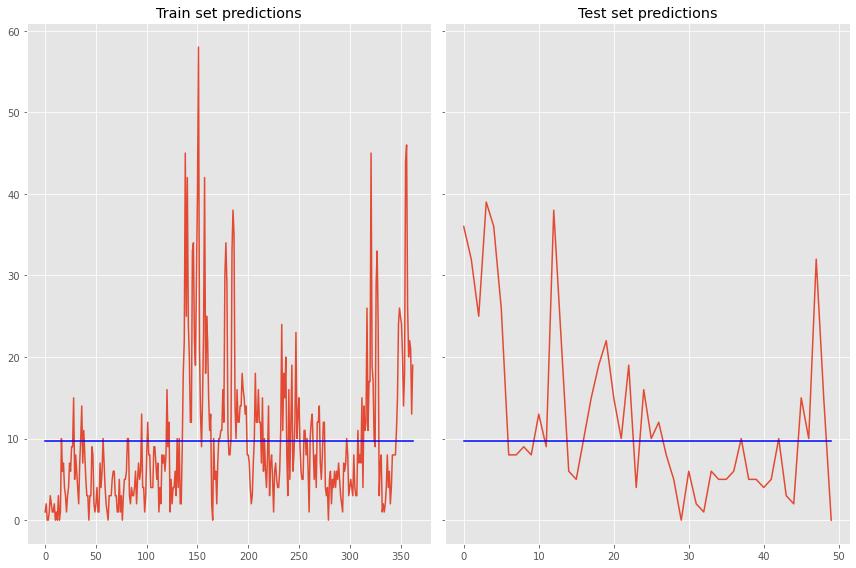

In [327]:
fig, ax = plt.subplots(ncols=2, figsize=(12,8), sharey=True)

ax[0].plot(y_train)
ax[0].plot(train_pred, color='blue')
ax[0].set_title("Train set predictions")

ax[1].plot(y_test)
ax[1].plot(test_pred, color='blue')
ax[1].set_title("Test set predictions")

plt.tight_layout()
plt.show()

In [328]:
mae_train  = mean_absolute_error(y_train, train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred)) 

mae_test   = mean_absolute_error(y_test, test_pred)
rmse_test  = np.sqrt(mean_squared_error(y_test, test_pred))

scores['baseline_mean'] = {'mae': mae_test, 
                           'rmse':rmse_test}

In [329]:
print(scores['baseline_mean'])

{'mae': 7.64, 'rmse': 10.852949216214796}


#### Baseline 0

In [330]:
mae_train  = mean_absolute_error(y_train, np.zeros(y_train.shape))
rmse_train = np.sqrt(mean_squared_error(y_train, np.zeros(y_train.shape))) 

mae_test   = mean_absolute_error(y_test, np.zeros(y_test.shape))
rmse_test  = np.sqrt(mean_squared_error(y_test, np.zeros(y_test.shape)))

scores['baseline_zero'] = {'mae': mae_test, 
                           'rmse':rmse_test}

In [331]:
print(scores['baseline_zero'])

{'mae': 12.64, 'rmse': 16.40243884305014}


### Linear Regression

In [276]:
from sklearn.linear_model import LinearRegression

In [332]:
model = LinearRegression()
model = model.fit(X_train, y_train)

In [333]:
y_pred = model.predict(X_test)

In [334]:
y_pred[y_pred < 0] = 0

In [335]:
model.coef_

array([ 3.28336880e+00, -1.75077001e-02, -1.78919610e-02, -4.89851617e-01,
       -2.78401934e-02,  8.71543788e-03, -6.02598299e-03,  3.07602628e-04,
        3.73137909e+00, -2.92566736e+00,  2.99532464e+00,  2.41078058e+00,
       -2.94999950e+00, -7.45122370e-01,  5.83909337e-01,  7.43086994e-02,
       -1.49413606e-01,  9.36770130e-02,  2.61171816e-02,  1.17490567e-01,
       -1.22441055e-02, -1.01045882e-01,  1.00602910e-01,  5.57822735e-03])

In [336]:
model.intercept_

-6609.6728807670415

In [337]:
mae_test   = mean_absolute_error(y_test, y_pred)
rmse_test  = np.sqrt(mean_squared_error(y_test, y_pred))

scores['LinearRegression'] = {'mae': mae_test, 
                              'rmse':rmse_test}

In [338]:
scores['LinearRegression']

{'mae': 8.443757795350667, 'rmse': 9.917247908273804}

In [339]:
# Original Values
lr = model.intercept_ + np.dot(X, model.coef_)
lr[lr < 0 ] = 0
# Scaled data
#lr = model.intercept_ + np.dot(scaled_data[:,:-1], model.coef_)

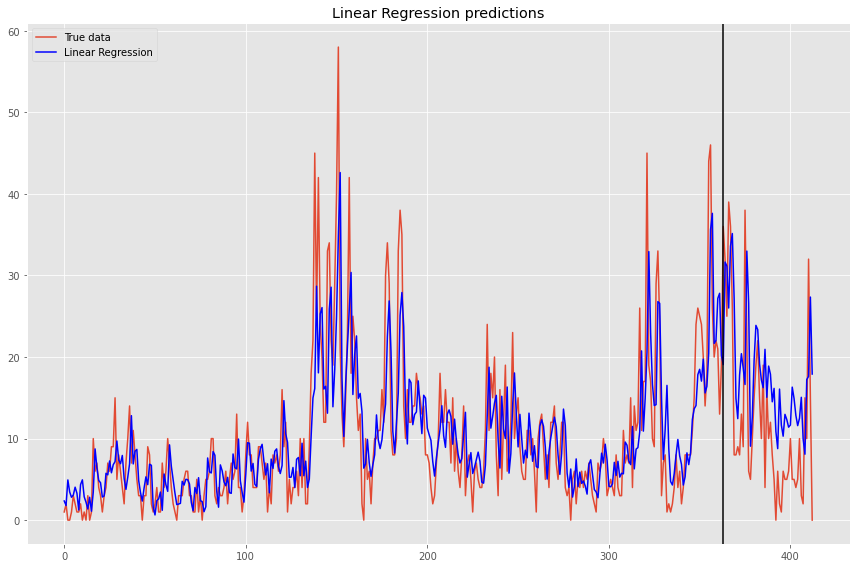

In [340]:
fig, ax = plt.subplots(figsize=(12,8))

## True values
ax.plot(df.y.values, label='True data')

## Scaled data
# ax.plot(scaled_data[:,-1], label='True data')

ax.plot(lr, color='blue', label='Linear Regression')
plt.axvline(x=split_point, color='black')
ax.set_title("Linear Regression predictions")

plt.legend()

plt.tight_layout()
plt.show()

### Decision Trees

### XGBoost

In [341]:
import xgboost as xgb

In [342]:
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test  = xgb.DMatrix(X_test, label=y_test)

##### Hyperparameters

In [343]:
param = {
    'max_depth':5,
    'eta':0.01,
    'objective': 'reg:squarederror',
    'booster':'gblinear',
    'eval_metric': ['mae', 'rmse'],
}
epochs = 1000

In [344]:
model = xgb.train(param, xgb_train, epochs)

In [345]:
train_predictions = model.predict(xgb_train)
train_predictions[train_predictions < 0] = 0

# black friday
#train_predictions[train_predictions == max(train_predictions)] = sum(train_predictions)*0.08

In [346]:
test_predictions  = model.predict(xgb_test)
test_predictions[test_predictions < 0] = 0

In [347]:
mae_test   = mean_absolute_error(y_test, test_predictions)
rmse_test  = np.sqrt(mean_squared_error(y_test, test_predictions))

scores['XGBoost'] = {'mae': mae_test, 
                     'rmse':rmse_test}

In [348]:
print(scores['XGBoost'])

{'mae': 6.68089991569519, 'rmse': 8.675347225868848}


In [349]:
xgb_predictions = np.append(train_predictions, test_predictions)

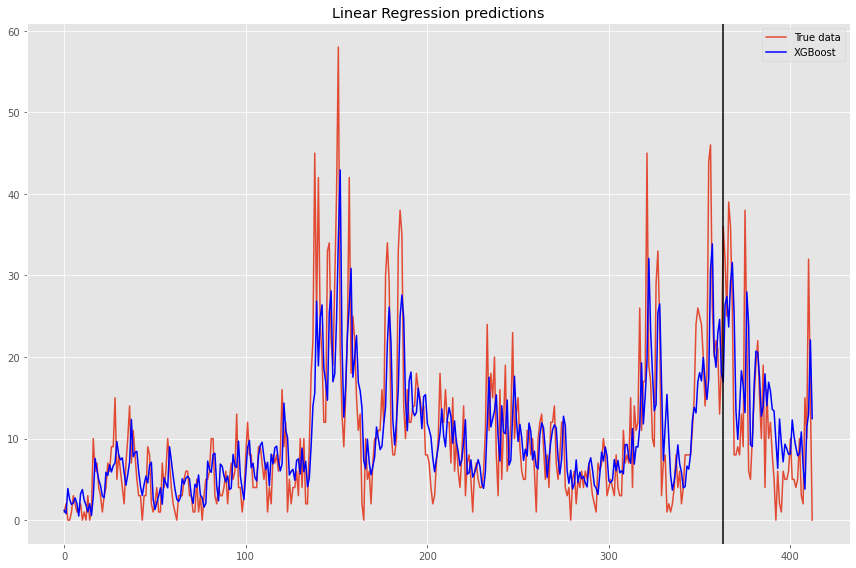

In [350]:
fig, ax = plt.subplots(figsize=(12,8))

## True values
ax.plot(df.y.values, label='True data')

## Scaled data
# ax.plot(scaled_data[:,-1], label='True data')

ax.plot(xgb_predictions, color='blue', label='XGBoost')
plt.axvline(x=split_point, color='black')
ax.set_title("Linear Regression predictions")

plt.legend()

plt.tight_layout()
plt.show()

In [298]:
df.sort_values(by='y', ascending=False).head(10)[['ds','year','month','day','dayofweek','y']]

,ds,year,month,day,dayofweek,y
161,2019-06-12,2019,6,12,2,58.0
366,2020-01-03,2020,1,3,4,46.0
148,2019-05-30,2019,5,30,3,45.0
331,2019-11-29,2019,11,29,4,45.0
365,2020-01-02,2020,1,2,3,44.0
167,2019-06-18,2019,6,18,1,42.0
150,2019-06-01,2019,6,1,5,42.0
160,2019-06-11,2019,6,11,1,40.0
376,2020-01-13,2020,1,13,0,39.0
385,2020-01-22,2020,1,22,2,38.0
